# Day 2 part 2: Introducing transmission dynamics

<div style="background: #f8f9fa; padding: 0.5rem 1rem; border-radius: 8px; margin-bottom: 1rem; border-left: 4px solid #007bff;">
<a href="../../index.ipynb" style="text-decoration: none; color: #007bff; font-weight: bold;">← Back to Course Index</a> | 
<a href="../../index-tr.ipynb" style="text-decoration: none; color: #dc3545; font-weight: bold;">🇹🇷 Türkçe Index</a>
</div>

---

We have built a SIR model, have explored how variation in main model parameters can affect the epidemic size and have assessed model outputs from a fully dynamic SIR model. In theory we have explored concepts of R0, Reff , herd immunity threshold and population renewal. In this practice we will build in our previous practice to explore these concepts further.

## 1. A model for COVID-19

SARS-Cov2 actively transmitted form human to human in virtually every country of the world for the past 2 years. Since the end of 2019 we have accrued important insights into the core dynamics of the virus and have been able to quantify important parameters to describe its transmission. Here we will adapt our previous SIR model to reflect important characteristics of SARS-Cov2, and will rely on published literature to inform our model.

We know that SARS-Cov2 is transmitted human to human, we also know that transmission is followed by an incubation period which ends with most individuals developing a symptomatic form of the disease. Individuals are not infectious during the incubation period. Liu et al, 2020, in their systematic review have estimated an R0 value with median of 2.79 (ranging from 1.5 to 6.68)(1). Similarly, McAloon et al have reviewed the duration of the incubation period and found a mean value of 5.8 days (CI95% 5-6.7)(2). The infectious period is one of the most heterogeneous pieces of information given the wide variations in disease severity. However, for simplicity we can say that the average infectious period (from symptom onset to having a negative PCR) is \~ 13 days, as reported elsewhere (3). Finally, the case fatality rate for covid-19 is understood to follow important age patterns and also between country variations. However, for simplicity we will take an estimate of 4% (4).

### Case study

You have been commissioned to write a simple model to project the likely course of the epidemic over the next year (if no interventions are introduced). The population of interest is a town of 100,000 people. At the moment a population wide screening has found 500 infectious cases.

1)  Following the text above, can you design a model that includes the relevant disease stages, and can you define the transitions rates accordingly? (use pen and paper).

2)  Given you have designed a model for Covid-19, can you write down the differential equations for this model?

3)  Using the code below (from our previous practice), try to modify your code to introduce the new model features.\

4)  Once you run your model, can you provide the following information:

<!-- -->

a)  What is the expected size of the epidemic one year from now?

    **Answer:** \~88,220 people

b)  How many deaths are projected to occur under the current conditions?

    **Answer:** \~3,675

c)  When will the epidemic peak?

    **Answer: \~83 days**

d)  Given the current knowledge about this epidemic, what is the value for herd immunity threshold?

    **Answer:**

    **HIT = 1 - 1/R0**

    **HIT = 1- 1/2.79 = 0.64; Meaning that bringing immunity to 64% of the population results in epidemic decay.**

Note: Look for the question marks (?) and replace as necessary.

here() starts at C:/Users/juano/Dropbox/Code/Git/ankara-modelling-2025-notebooks

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


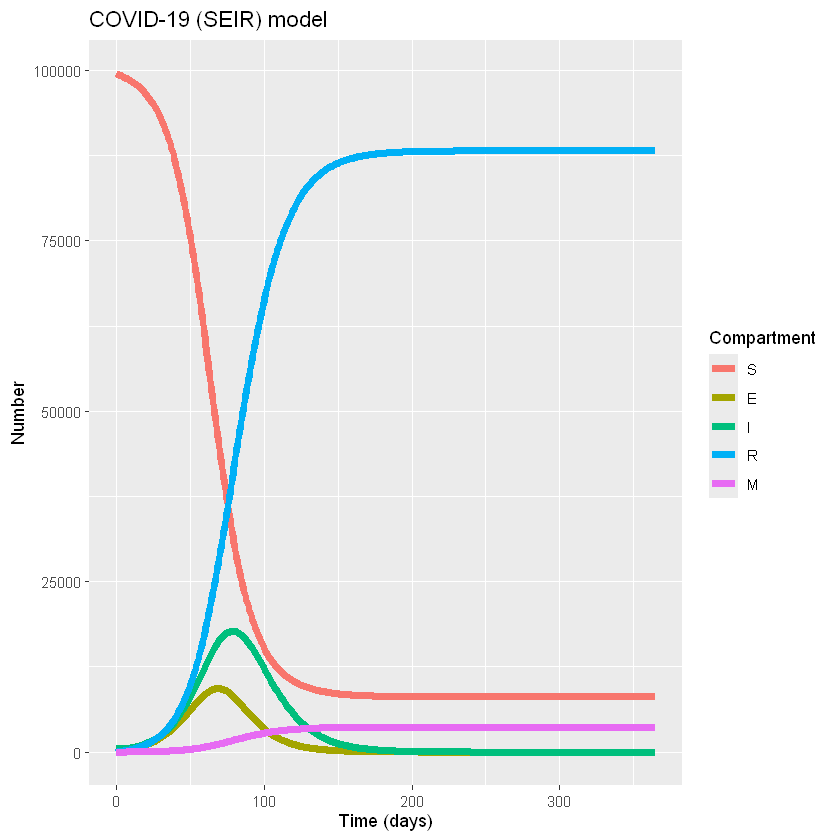

In [1]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)
library(here)

setwd(here())
# Population size:
N <- 100000

# MODEL INPUTS:

# Initial conditions
initial_state_values <- c(
  S = N-500,    # <------------Write initial conditions for S
  E = 0,
  I = 500,    # <----------- Write initial conditions for I
  R = 0,
  M = 0)           

# Parameter values per day  <--------------Complete the following model parameters

epsilon <- 1/5.8    # onset of symptoms rate  
gamma   <- 1/13     # Recovery rate 
R0      <- 2.79      # R0
beta    <- R0/13       # infection rate
CFR     <- 0.04       # Case fatality rate
mu      <- gamma*CFR/(1-CFR)       # Mortality rate [remember competing hazards! gamma*CFR/(1-CFR) ]


parameters <- c(beta,epsilon, gamma, mu)


# MODEL FUNCTION: 
times <- seq(from = 0, to = 365, by = 1)   # from 0 to 365 days in daily intervals

seir_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {     
    
    # Calculating the total population size N (the sum of the number of people in each compartment)
    
    N <- S+E+I+R  # <----------------- define the total population
    
    # Calculating the FOI
    
    lambda <- beta*I/N  #  How can we define the force of infection? 
    
    # The differential equations
    dS <-  -lambda*S 
    dE <-   lambda*S - E*epsilon      # Can you write the differential equation for E? 
    dI <-   E*epsilon - I*(gamma+mu)     
    dR <-   gamma * I 
    dM <-   I*mu
    
    return(list(c(dS, dE, dI, dR, dM))) 
  })
  
}


# MODEL OUTPUT (solving the differential equations):

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = seir_model,
                            parms = parameters))



# turn output data set into long format
output_long <- melt(as.data.frame(output), id = "time")                 


# Plot the number of people in the S, I and R compartments over time
ggplot(data = output_long,                                               # specify object containing data to plot
       aes(x = time, y = value, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line(size=2) +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Number") +                                                       # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "COVID-19 (SEIR) model")    
   


## 2. Effective reproductive number

You have provided very useful insights for planning the epidemic response. The health authorities are planning to introduce vaccination in the next 40 days.

1)  what is the expected effective reproduction number in 40 days ?

**Answer: \~ 2.4**

Use the code below to estimate the proportion of population in each stage of the model over time.

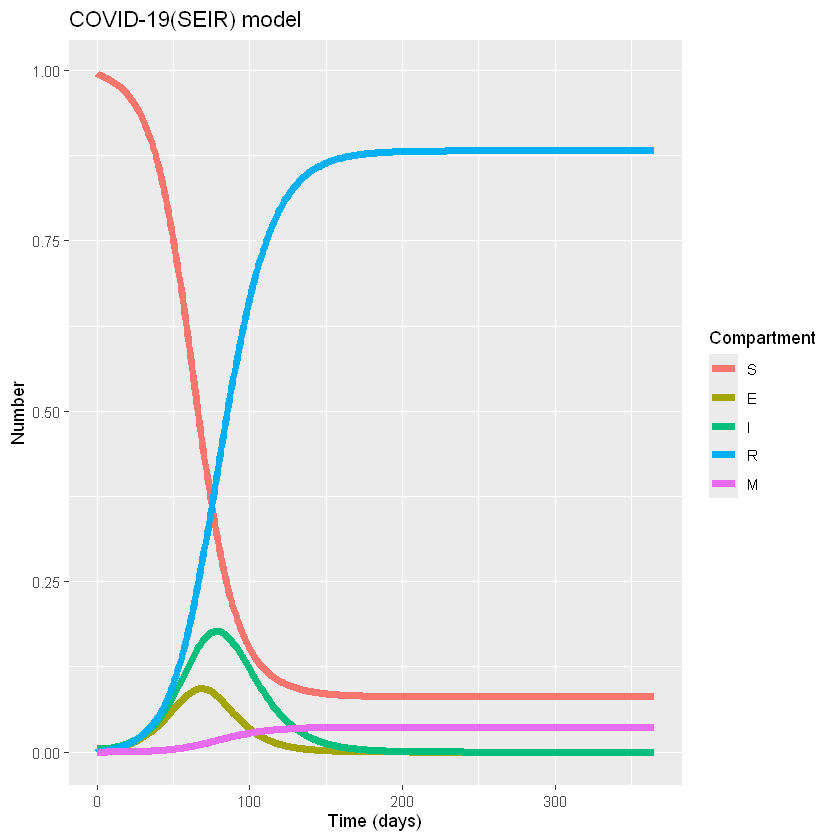

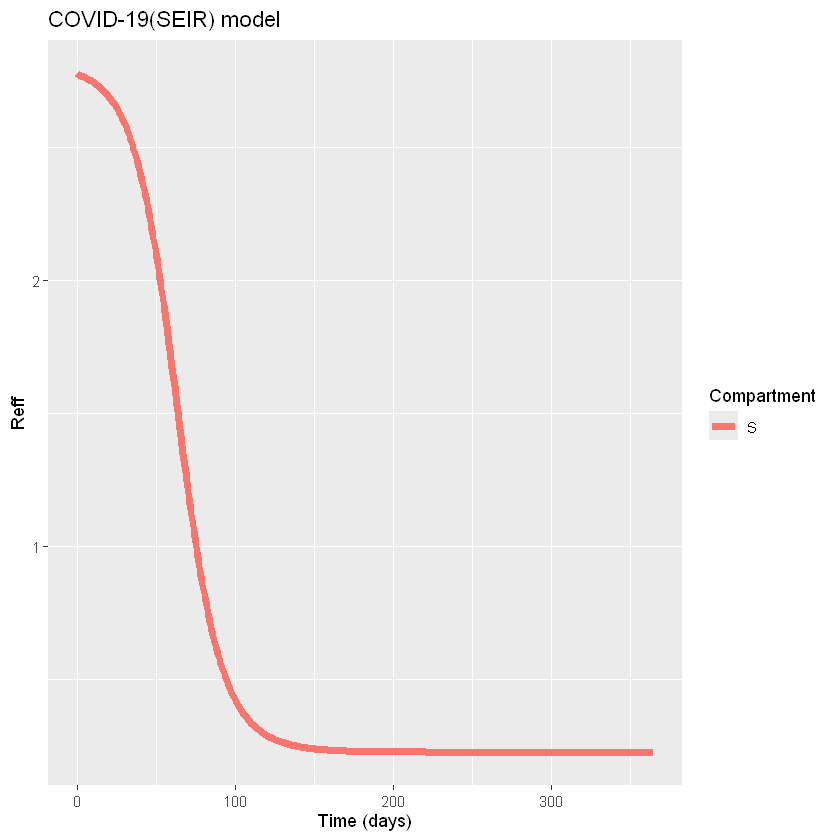

In [2]:
# Plot the proportion of individuals 

output2_long<- output_long
output2_long$value<-output_long$value/N

# Plot the proportion of people in the S, I and R compartments over time
ggplot(data = output2_long,                                               # specify object containing data to plot
       aes(x = time, y = value, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line(size=2) +                                                    # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Number") +                                                       # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "COVID-19(SEIR) model")



## Calculate Reff

Reff<-output2_long[output2_long$variable=="S",] # this is the proportion susceptible over time

Reff$value<- Reff$value * R0 #<------------- Complete the calculation for Reff
  
  # Plot the proportion of people in the S, I and R compartments over time
  ggplot(data = Reff,                                               # specify object containing data to plot
         aes(x = time, y = value, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line(size=2) +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Reff") +                                                       # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "COVID-19(SEIR) model")

2)  You are asked to explain why your model does not reproduce subsequent waves as have been seen in other contexts. Can you think of what assumptions and simplifications are preventing that behavior in your model?

    **Answer:** **We are modelling a closed cohort of people, which means that there is no renewal of the susceptible pool of people. Also, we are not allowing any seasonality (changing in contact patterns over the year, or other external factors that might cause variations in transmission)**

3)  Can you think of potential model designs to simulate vaccination?

    **Answer: Add an extra flow from S to a new compartment V. This transmission should reflect the coverage. And importantly, vaccine efficacy should be stated as a fraction that fails to move to "V" or it could mean a reduction in force of infection from "V"**

## References

1.  Liu Y, Gayle AA, Wilder Smith A, Rocklov J. Reproductive number of Covid19 is higher compared to SARS coronavirus. J Travel Med. 2020;27(2):taaa021. doi: 10.1093/jtm/taaa021.
2.  McAloon C, Collins Á, Hunt K, et alIncubation period of COVID-19: a rapid systematic review and meta-analysis of observational researchBMJ Open 2020;10:e039652. doi: 10.1136/bmjopen-2020-039652
3.  Byrne AW, McEvoy D, Collins AB, et alInferred duration of infectious period of SARS-CoV-2: rapid scoping review and analysis of available evidence for asymptomatic and symptomatic COVID-19 casesBMJ Open 2020;10:e039856. doi: 10.1136/bmjopen-2020-039856
4.  Verity, R. et al. Estimates of the severity of coronavirus disease 2019: a model-based analysis. Lancet Infect. Dis. 20, 669--677 (2020).